<a href="https://colab.research.google.com/github/elyober/G15PracticaProfesionalizanteISPC/blob/main/ModeloRegresionLogistica_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Modelo de regresión logística para analisis de sentimientos<center>**

##   Vamos a entrenar un modelo de regresion logística para la clasificacion de sentimientos en los comentarios de redes sociales y de ventas.
##   Nuestra meta es medir el sentimiento asociado por los clientes hacia la marca . Para ello este modelo será entrenado con el data set data_sentimientos.csv el cual es una pequeña modificación del data set propuesto por Amazon Home_and_Kitchen_5.json el cual posee cerca de 7 millones de rewies que los usuarios de amazon han hecho sobre ariculos de cocina. Link  [https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/]


### Citacion del artículo:
### Justifying recommendations using distantly-labeled reviews and fined-grained aspects
###Jianmo Ni, Jiacheng Li, Julian McAuley
###Empirical Methods in Natural Language Processing (EMNLP), 2019




In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np


In [ ]:
#cargamos el dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/data_sentimientos.csv")

## una ves cargado el data set vamos a verificar que tan representadas estan las etiquetas de sentimiento.

In [ ]:
#Agrupando y contando las etiquetas
df2= df.groupby(["sentimiento_marca"])["sentimiento_marca"].count()
print(df2)

sentimiento_marca
Excelente    4688044
Neutra        513982
Pesima        374016
Positiva     1033449
negativa      289464
Name: sentimiento_marca, dtype: int64


#Graficámos para ilustrar los resultados.


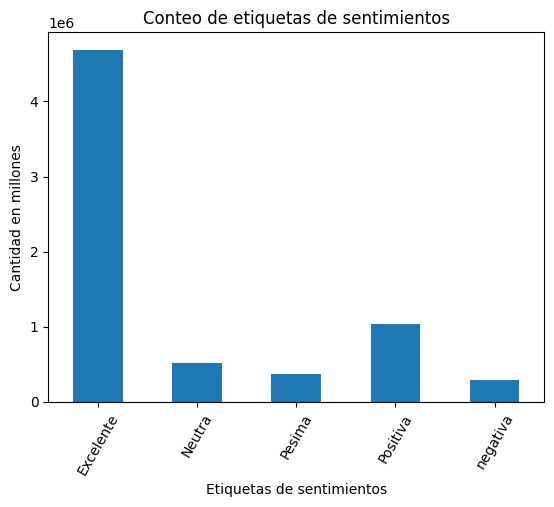

In [ ]:
import matplotlib.pyplot as plt
#rot es un parametro de rotacion para las etiquetas.
df2.plot(kind='bar', rot=60)
plt.xlabel("Etiquetas de sentimientos")
plt.ylabel("Cantidad en millones")
plt.title("Conteo de etiquetas de sentimientos\n")
plt.show()


## Como pudimos observar la muestra posee considerablemente más etiquetas asociados con un sentimiento excelente, el cual esta sobre representado. Por ello decidimos decidimos igualar las etiquetas de sentimiento a 20.000 muestras aleatorias de cada una.  

In [ ]:
df["reviewText"] = df["reviewText"].astype(str)
df["sentimiento_marca"]= df["sentimiento_marca"].astype(str)
#como la muestra posee considerablemente mas etiquetas de excelente, dejamos cada etiqueta con un 20% en un nuevo conjunto
#para abordar el desequlibrio de clases y que todas las etiquetas esten bien representadas.

#obteniendo varios valores aleatorios para cada etiqueta.
excelente_df = df.loc[df["sentimiento_marca"] == "Excelente"].sample(n=20000, random_state=42)
negativa_df = df.loc[df["sentimiento_marca"] == "negativa"].sample(n=20000, random_state=42)
pesimo_df = df.loc[df["sentimiento_marca"] == "Pesima"].sample(n=20000, random_state=42)
neutro_df = df.loc[df["sentimiento_marca"] == "Neutra"].sample(n=20000, random_state=42)
positivo_df = df.loc[df["sentimiento_marca"] == "Positiva"].sample(n=20000, random_state=42)
#concatenando y redistribuyendo la muestra
combinado_df = pd.concat([excelente_df, negativa_df, pesimo_df, neutro_df, positivo_df])
#frac=1 para tomar el 100% de los datos de forma aleatoria, reset_index(drop=True ) para descartar el indice anterior y crear uno nuevo.
combinado_df = combinado_df.sample(frac=1).reset_index(drop=True)
print(combinado_df.head())

   Unnamed: 0.1  Unnamed: 0  overall  \
0       1297056     1297056      1.0   
1        761764      761764      2.0   
2       6672036     6672036      5.0   
3       3357707     3357707      4.0   
4       4688153     4688153      3.0   

                                          reviewText  \
0  The bags were not what I expected. They were c...   
1  It has come apart and I am unable to use  the ...   
2  This throw is super warm and exactly what my d...   
3  Doesn't toast evenly, but works pretty well. W...   
4  Looks-wise it's super cool. But the handle des...   

                                             summary sentimiento_marca  
0  I was going to use them for some Easter crafts...            Pesima  
1                                          Two Stars          negativa  
2                                         Five Stars         Excelente  
3  but works pretty well. What can you expect fro...          Positiva  
4  Looks-wise it's super cool. But the handle des...     

## Dividimos el data set para el entrenamiento.

In [ ]:
# dividimos el dataset para el enrenamiento.
X_train = combinado_df.loc[:75000, 'reviewText'].values
y_train = combinado_df.loc[:75000, 'sentimiento_marca'].values
X_test = combinado_df.loc[75000:100000, 'reviewText'].values
y_test = combinado_df.loc[75000:100000, 'sentimiento_marca'].values

In [ ]:
!pip install nltk

## tokenizer_porter es utilizado para declinar palabras, es decir, para devolver los verbos a su forma raiz para el análisis. De esta manera palabras como corriendo, leyendo serán devueltas como correr, leer. Esta función devuelve una lista con dichas palabras.
## Stop.words es utilizado para no contar palabras vacias, es decir, palabras que no agregan valor o contexto al análisis.  

In [ ]:
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#tfidf se refiere a la frecuencia de terminos en una oracion.
#TfidfVectorizerse utiliza para la transformacion del texto.
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)
#La penalización L2 es comúnmente utilizada en la regresión logística para evitar el sobreajuste
# y controlar la magnitud de los coeficientes del modelo
param_grid = [{'vect__ngram_range': [(1, 3)],
                   'vect__stop_words': [stop],
                   'vect__tokenizer': [tokenizer_porter],
                   'clf__penalty': ['l2'], # anteriormente se ejecuto incluyendo penalty 'l1' pero resulto incompatible.
                   'clf__C': [1.0, 10.0]
                    },
                  ]
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, max_iter=1000))]) # max_iter=1000 para que el algoritmo converga

#configurar y realizar una búsqueda de hiperparámetros utilizando la técnica de validación cruzada mediante GridSearchCV
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy', #scoring= 'accuracy' evaluará la precisión del modelo.
                           cv=5,
                           verbose=1,
                           n_jobs=1)
#cv=5 lo que significa es que se realizará una validación cruzada de 5-fold. Esto implica que los datos se dividirán en 5 partes iguales, y se realizarán 5 iteraciones de entrenamiento y evaluación.

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

In [ ]:
print('El mejor conjunto de parametros es : %s ' % gs_lr_tfidf.best_params_)
print('Precision de GridSearchCV: %.3f' % gs_lr_tfidf.best_score_)

El mejor conjunto de parametros es : {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 3), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('Test de precision: %.3f' % clf.score(X_test, y_test))

Test de precision: 0.508


##<center>Reporte del modelo. <center>

In [ ]:
from sklearn.metrics import classification_report
y_pred = gs_lr_tfidf.predict(X_test)
report = classification_report(y_test, y_pred)
print("Informe de Clasificación:")
print(report)

Informe de Clasificación:
              precision    recall  f1-score   support

   Excelente       0.64      0.67      0.65      5047
      Neutra       0.44      0.38      0.41      5036
      Pesima       0.56      0.63      0.59      4992
    Positiva       0.46      0.50      0.48      4966
    negativa       0.41      0.36      0.38      4959

    accuracy                           0.51     25000
   macro avg       0.50      0.51      0.50     25000
weighted avg       0.50      0.51      0.50     25000



##  Dado que el modelo esta entrenado con reseñas en ingles, hacemos una prueba con oraciones en dicho idioma.

In [ ]:
x_p = ["Very bad, when cooking on low heat it burns, when cooking if something is a little too much it gets stained and can not be cleaned, you have to leave the handle well outside the fire because it burns. The battery is not even a month old and that's how they are. Deplorable I would never buy again this brand of pots hudson. Very bad and the company that distributes them is clearly not responsible. They are not good for anything these pots, they burn even to fry an egg! very bad and more for what they cost.",
       "The truth is that I am very happy with my purchase. Besides being very nice the material is phenomenal. I tried it and I'm more than happy haha. I recommend it, the truth is that it is not bad money.",
       "Good design, good quality but the pancake holder sticks.",
       "After the first use, the pans were stained. One of them was also stained at the bottom by the fire and the handle also came loose.",
       "I would not buy them again. I take great care of them and wash them every time I use them, and yet they stain in a way that they just don't come out anymore. I have had them for a month and they are like that. I always put oil on them, I don't know why the stain is so impregnated. Anyway. It fulfills its function but they stain for nothing. In a few months you won't even see their granite details.",
       "Very nice product, they are very nice and the food does not burn or stick. Excellent.",
       "I was fascinated by the cookware set, love the color!!! I highly recommend it.",
       "Very very beautiful, practical and very good quality!!! I loved it!!!."]
y_p = gs_lr_tfidf.best_estimator_.predict(x_p)
print(y_p)

['Pesima' 'Excelente' 'Positiva' 'Pesima' 'negativa' 'Positiva'
 'Excelente' 'Excelente']


## el modelo clasifica bien las etiqutas de sentimientos, con la salvacion de que al modelo se le complica predecir las reseñas neutras. Las demas reseñas a pesar de su puntaje en precisión y en escore f-1, las resuelve de manera correcta.  

In [ ]:
!pip install joblib

## Al modelo le lleva mucho tiempo el entrenamiento, por lo tanto, este mismo será serializado para ser utilizado desde otro notebook o archivo y de ser necesaio, será comparado con otros modelos para precisar que modelo es el mejor para nuestra tarea.   

In [ ]:
import joblib
# Guardar el mejor estimador del GridSearchCV en un archivo
joblib.dump(gs_lr_tfidf.best_estimator_, "Regresion_en.pkl")


['Regresion_en.pkl']